In [3]:
## Some of the code seems to require Python 3

import sys
sys.version
import os
directory_name = "/make_quantum_jump_trajectories/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)
    
import itertools
import build_markov
# from hmmlearn import hmm
import warnings
warnings.filterwarnings("ignore")
from imp import reload

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

## Sometimes Macs will have an issue with Matplotlib, this seems to fix it.
## see http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python

import matplotlib as mil
mil.use('TkAgg')

In [4]:
reload(build_markov)

<module 'build_markov' from '/Users/gil/Google Drive/repos/diffusion_maps/build_markov.py'>

In [5]:
from build_markov import contour_plot

In [6]:
from sample_systems import *

In [7]:
import numpy.linalg as la

In [8]:
from scipy.stats import gaussian_kde

## Plot density
def plot_density(x,y,s = 10):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig = plt.figure(0,)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )

    ax.scatter(x, y, c=z, s=s, edgecolor='')

In [9]:
from sklearn.cluster import DBSCAN

#### Examples based on scikit learn tutorial:
#### http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

def run_DBSCAN(X, eps = 0.8, min_samples = 200):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)
    return labels, n_clusters_, core_samples_mask

def plot_DBSCAN(X,labels, core_samples_mask):
    plt.figure(figsize=(10,10))
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=4, markeredgewidth = 0)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=4, markeredgewidth = 0)

In [10]:
def all_equal(lst):
    return all([el == lst[0]  for el in lst]) 

In [11]:
def make_clusters(X, labels, max_range):
    '''
    Make a dict mapping label to points in the cluster
    '''
    return {i:X[np.asarray([j for j in range(max_range)
                if labels[j] == i ])]
                    for i in set(labels) }

def match_clusters(cs):
    '''
    Ensures the labels between clusters c1 and c2 match
    '''
    means_lst = [{i:np.average(v, axis = 0) for i,v in c.items() if i != -1} for c in cs]
    labels_map = {}
    for l,means in enumerate(means_lst[1:]):
        labels_map[l] = {}
        for i,m in means.items():
            j = np.argmin([la.norm(m-v) for k,v in means_lst[0].items()])
            labels_map[l][i] = j
        labels_map[l].update({-1:-1})
    return labels_map

In [12]:
def get_tran_matrix(labels_in,):
    init_label = next((i for i, x in enumerate(labels_in) if x != -1), None) ## first label in labels_in
    lbl_current = labels_in[init_label]
    trans_count = np.asmatrix(np.zeros([len(set(labels_in))-1]*2))
    for lbl_in in labels_in:
        if (lbl_in != -1) and (lbl_current != lbl_in): 
            trans_count[lbl_in,lbl_current] += 1
            lbl_current = lbl_in
    return trans_count

In [13]:
def cluster_analysis(eps_try, min_samples = 200, swap_colors = None):
    '''
    Warning: This method currently relies on global variables, and will 
    work properly as executed inside this notebook only.
    '''
    lbls_lst = []
    for eps in eps_try:
        labels, _, _ = run_DBSCAN(X, eps = eps, min_samples=min_samples)
        lbls_lst.append(labels)

    ### Make sure all lists of labels have the same number of clusters
    assert all_equal([len(set(labels)) for labels in lbls_lst])
    
    
    ### Make labels consistent
    clusters_lst = [make_clusters(X,labels,int(duration)) for labels in lbls_lst]
    map_labels = match_clusters(clusters_lst)
    print (map_labels)
    lbls_lst_fixed = [lbls_lst[0]] + [[map_labels[n][l] for l in lbls] 
                                              for n,lbls in enumerate(lbls_lst[1:])]
    
    clusters_lst_fixed = [clusters_lst[0]] + [{map_labels[n][k]:v for k,v in clusters_lst[1:][n].items()} 
            for n in range(len(clusters_lst[1:]))]
    
    trans_count_lst = []
    for labels in lbls_lst_fixed:
        trans_count = get_tran_matrix(labels)
        trans_count_lst.append(trans_count)
    #     contour_plot(trans_count)
    
    plt.figure(1)
    plot_density(x,y,s = 50)
    means_lst = [{i:np.average(v, axis = 0) for i,v in c.items()} for c in clusters_lst_fixed]
    num_labels = len(set(labels)) - 1
    means = np.asarray([[el[i] for el in means_lst] for i in range(num_labels)])
    colors = plt.cm.Spectral(np.linspace(0.2, 1, num_labels))
    if not swap_colors is None:
        colors = np.asarray([colors[swap_colors[i]] for i in range(num_labels)])
    for n,i in enumerate(means):
        for j in i:
            plt.scatter(*j, c=colors[n],s=2000)
            
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.show()
    
    plt.figure(2)
    plt.figure(figsize=(10,10))
    for i in range(3):
        for j in range(3):
            if i != j:
                plt.plot(eps_try,np.asarray([T[i,j]-0.3 for T in trans_count_lst]).T, c = colors[j],linewidth = 2);
                plt.plot(eps_try,np.asarray([T[i,j]+0.3 for T in trans_count_lst]).T, c = colors[i],linewidth = 2);
    plt.ylim(0,200)
    plt.show()

In [14]:
reload(build_markov)

<module 'build_markov' from '/Users/gil/Google Drive/repos/diffusion_maps/build_markov.py'>

In [15]:
params = {alpha0 : 49., chi : -106.066, Delta : 750., kappa_1 : 220, kappa_2 : 1e-10,
          'Ntraj' : 1, 'duration' : 12000., 'Nfock' : 15}

In [16]:
## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']

Tsim = np.arange(0, duration/1000, 1e-3)
delta_t = Tsim[1] - Tsim[0]

In [34]:
slh_kerr_qnet, a_qnet = make_kerr_slh(index = 1,which_symbols='qnet',params=params)

In [35]:
## multiple Kerr SLH
slh_driven_kerr = (slh_kerr_qnet << Displace(alpha=params[alpha0])+cid(1)).toSLH()

In [36]:
a = a_qnet[0]
single_kerr_obs = tuple([a.dag()*a, a+a.dag(), (a-a.dag())/1j])
single_kerr_obsq = [o.to_qutip(full_space=slh_kerr_qnet.space) for o in single_kerr_obs]

In [55]:
mcdata_driven_kerr = make_traj(slh_driven_kerr, Tsim, single_kerr_obsq)

100.0%. Run time:  35.42s. Est. time left: 00:00:00:00
Total run time:  35.46s


## Build Markov Model for system 1

In [56]:
dim_red= build_markov.dim_red_builder(Regime= "kerr_bistable",
                sample_type = 'all',
                mcdata = mcdata_driven_kerr,)

In [57]:
dim_red.run_diffusion_map(eig_upper_bound = 7,eps = 0.5,)

In [58]:
markov_builder = build_markov.markov_model_builder(dim_red)

markov_builder.build_model(n_clusters = 40,which_coords = 'X')

converged True


### Original System 1

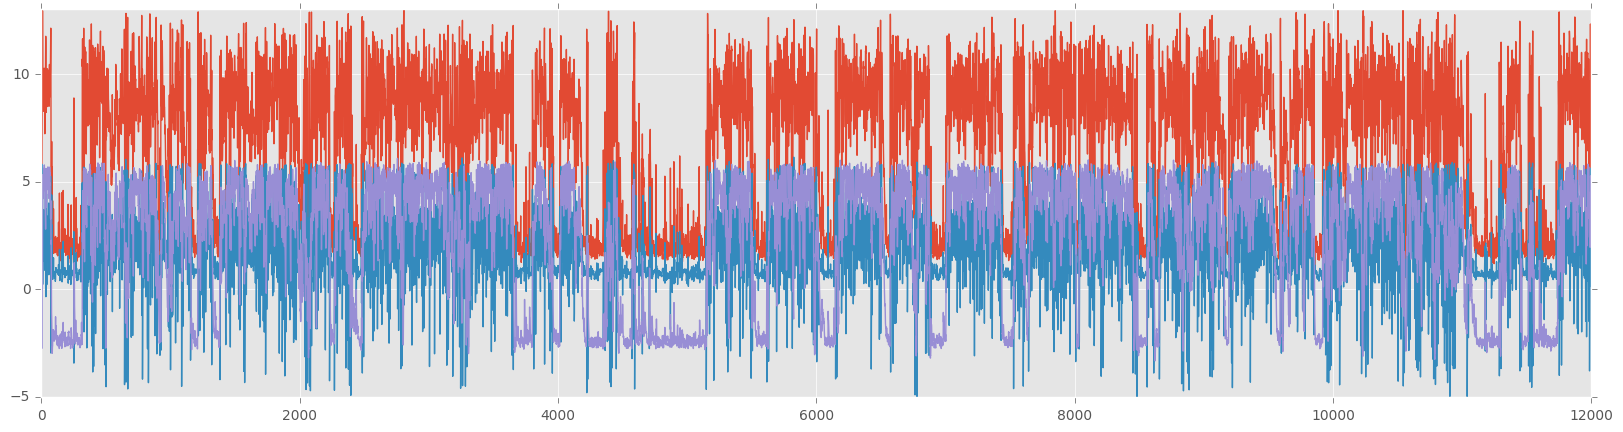

In [59]:
plt.figure(figsize=(20,5))
plt.plot(np.concatenate(mcdata_driven_kerr.expect).T[:,:3]);
plt.ylim(-5,13);

### HMM for system 1 only

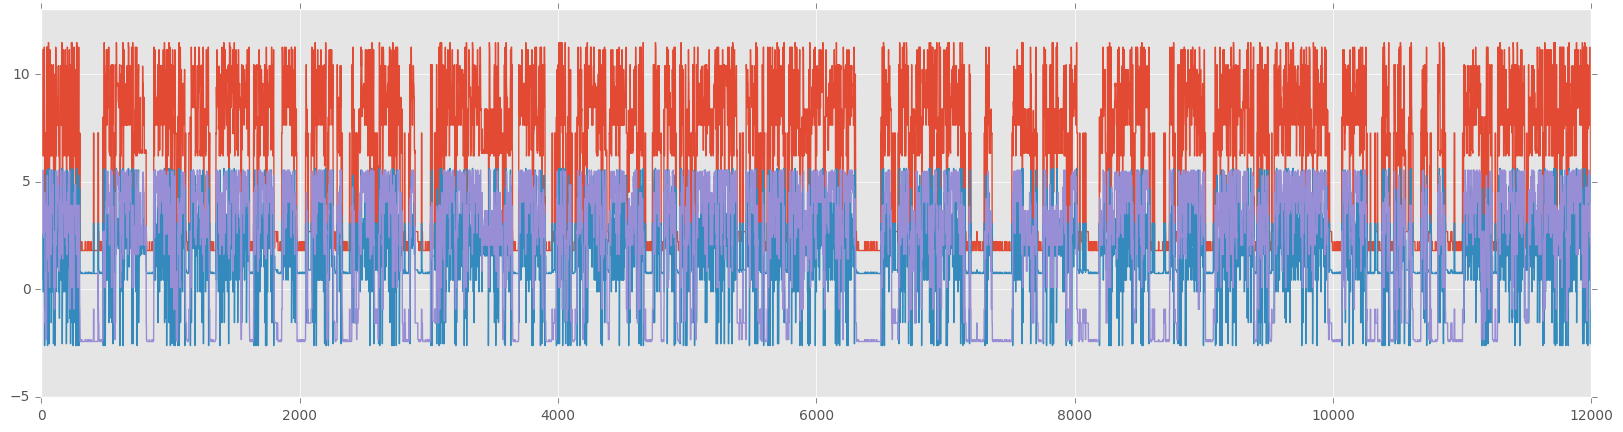

In [60]:
plt.figure(figsize=(20,5))
plt.plot(markov_builder.generate_obs_traj(int(duration)).T);
plt.ylim(-5,13);

## Hybrid Model $Red(S1) \to S2$

In [61]:
slh_kerr_sympy, sympy_symbols = make_kerr_slh(index = 0,which_symbols='sympy',params=params)
replacement_dict = {symbol : index for symbol, index in zip(sympy_symbols,range(3)) }
slh_12 = (slh_kerr_qnet << slh_kerr_sympy << Displace(alpha=params[alpha0])+cid(1)).toSLH()
slh_12

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-7.41619848709566*I*p - 7.41619848709566*x + 49.0, IdentityOperator), ScalarTimesOperator(2*sqrt(55), Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-5.0e-6*I*p - 5.0e-6*x, IdentityOperator), ScalarTimesOperator(1.00000000000000e-5, Destroy(LocalSpace('1', ''))))]]), OperatorPlus(ScalarTimesOperator(-53.033*N*(N + 1) + 750.0*N, IdentityOperator), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(49.0, OperatorPlus(ScalarTimesOperator(-7.41619848709566*I*p - 7.41619848709566*x, IdentityOperator), ScalarTimesOperator(2*sqrt(55), Destroy(LocalSpace('1', ''))))), ScalarTimesOperator(-49.0, OperatorPlus(ScalarTimesOperator(7.41619848709566*I*conjugate(p) - 7.41619848709566*conjugate(x), IdentityOperator), ScalarTimesOperator(2*sqrt(55), Create(LocalSpace('1', ''))))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(5.0e-11*I*p + 5.0e-11*x + 2*sqrt(55)*(7.41619848709566*I*p + 7.416

In [62]:
hybrid = build_markov.hybrid_model(slh_12,markov_builder,replacement_dict,single_kerr_obsq,delta_t,
                                   name = 'sys_12_diffusion')

### Generating a sample trajectory for the hybrid system

In [63]:
Ntraj_12 = 1
# hybrid.generate_trajectories(Tsim,Ntraj=Ntraj_12)
# hybrid.save()

hybrid.load()

100.0%. Run time: 13423.40s. Est. time left: 00:00:00:00
Total run time: 13423.54s


### Can we build a Markov model from system $Red(1) \to 2$?

In [64]:
reload(build_markov)

<module 'build_markov' from '/Users/gil/Documents/repos/diffusion_maps/build_markov.py'>

In [65]:
sys_12_outputs = hybrid.get_generated_trajs()
obs_indices_12 = range(sys_12_outputs.shape[-1])
dim_red_12 = build_markov.dim_red_simple(Ntraj_12, sys_12_outputs, obs_indices_12, "sys_12_test")

markov_builder_12 = build_markov.markov_model_builder(dim_red_12)
markov_builder_12.build_model(n_clusters = 60,which_coords = 'expects',covariance_type='spherical')
sys_12_expects = markov_builder_12.generate_obs_traj(int(duration)).T

converged True


### Original System 1

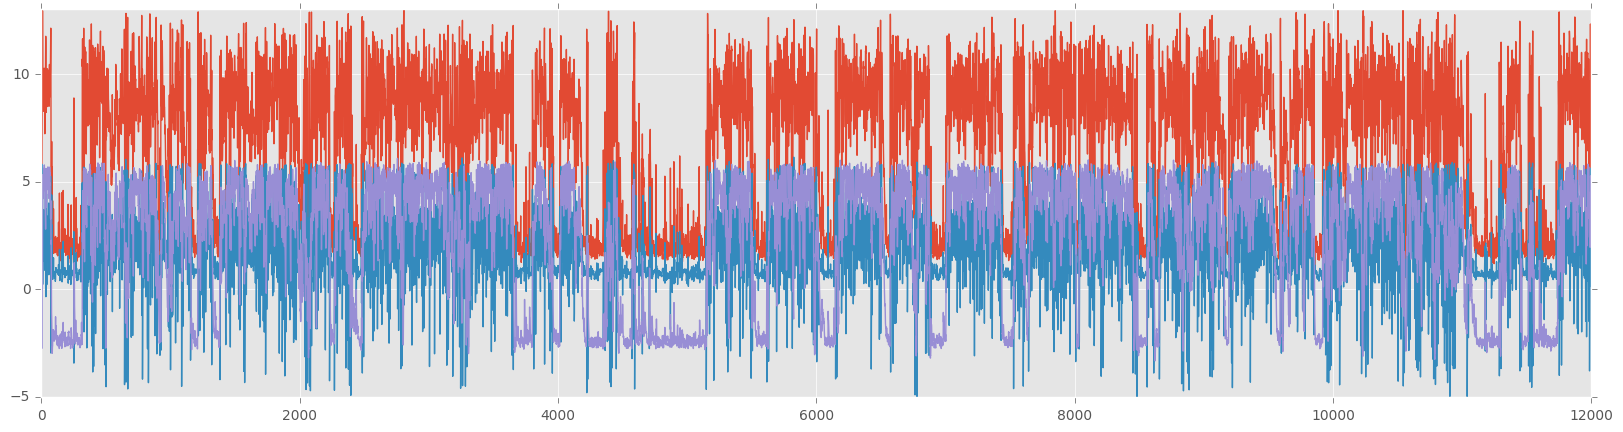

In [66]:
plt.figure(figsize=(20,5))
plt.plot(np.concatenate(mcdata_driven_kerr.expect).T[:,:3]);
plt.ylim(-5,13);

### HMM for system 1 only

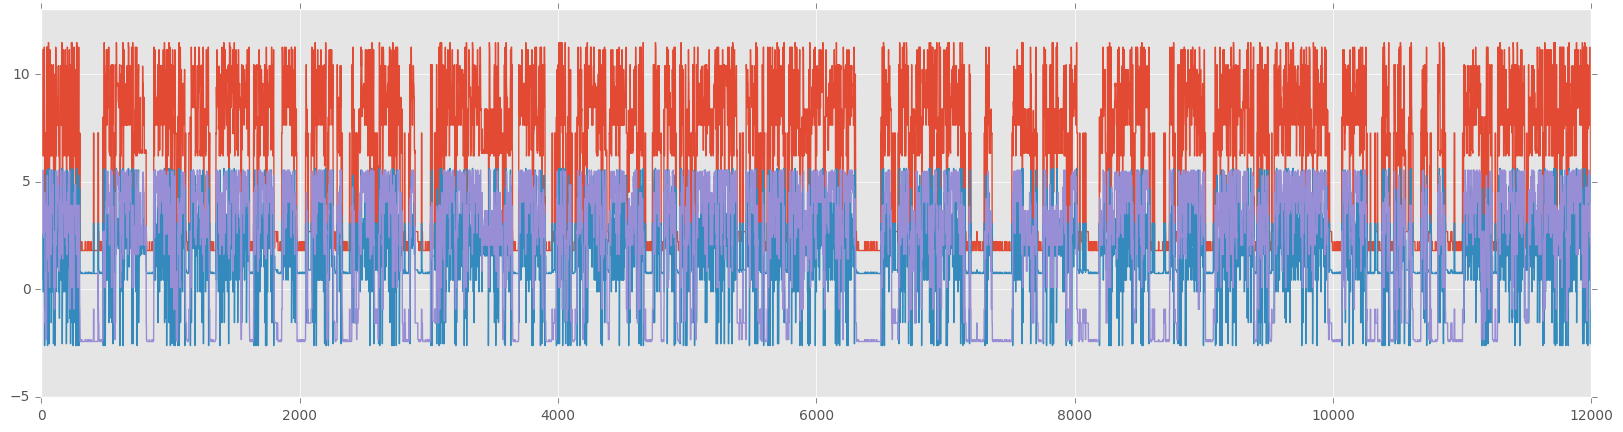

In [67]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_outputs[0,:,:3]);
plt.ylim(-5,13);

### Quantum system 2 with HMM inputs of system 1

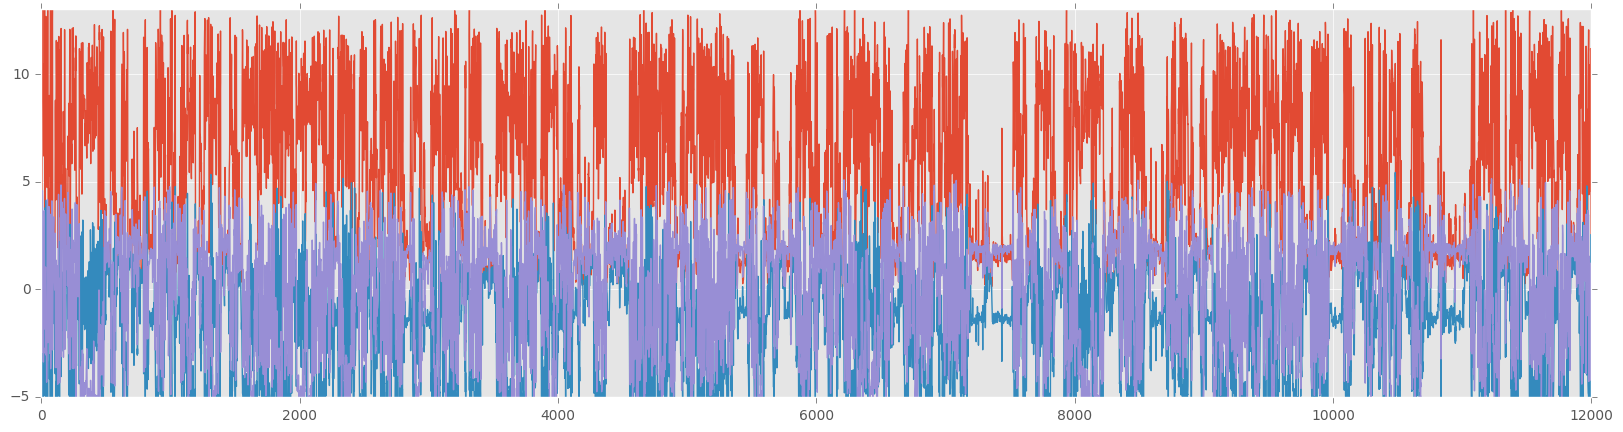

In [68]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_outputs[0,:,3:]);
plt.ylim(-5,13);

### System 1 observables from reduced system 1+2

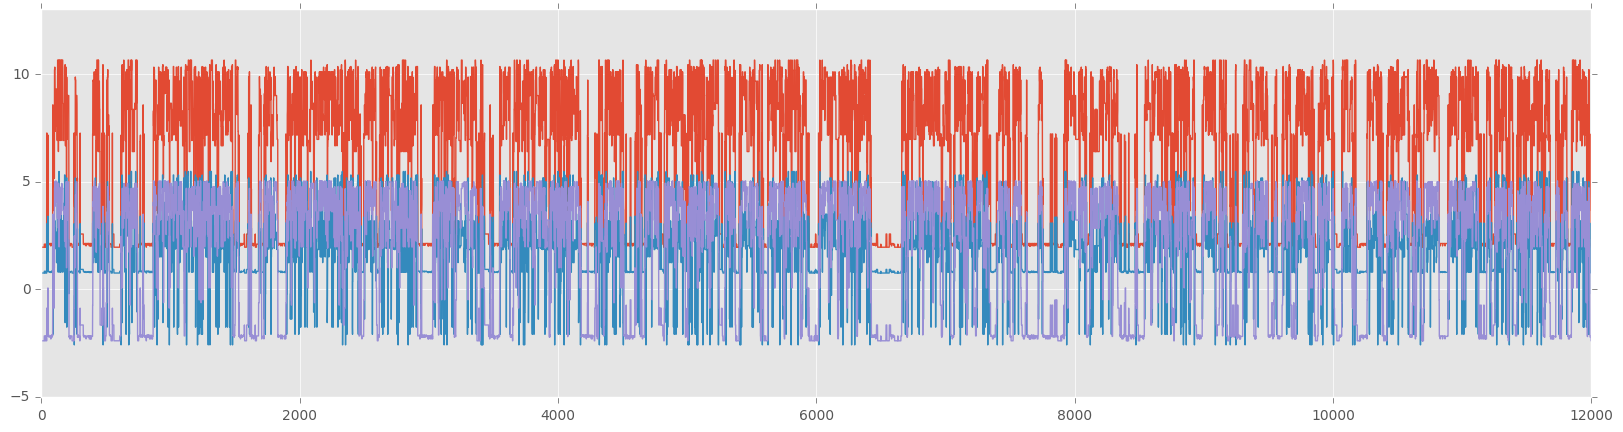

In [69]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_expects[:,:3]);
plt.ylim(-5,13);

### System 2 observables from reduced system 1+2

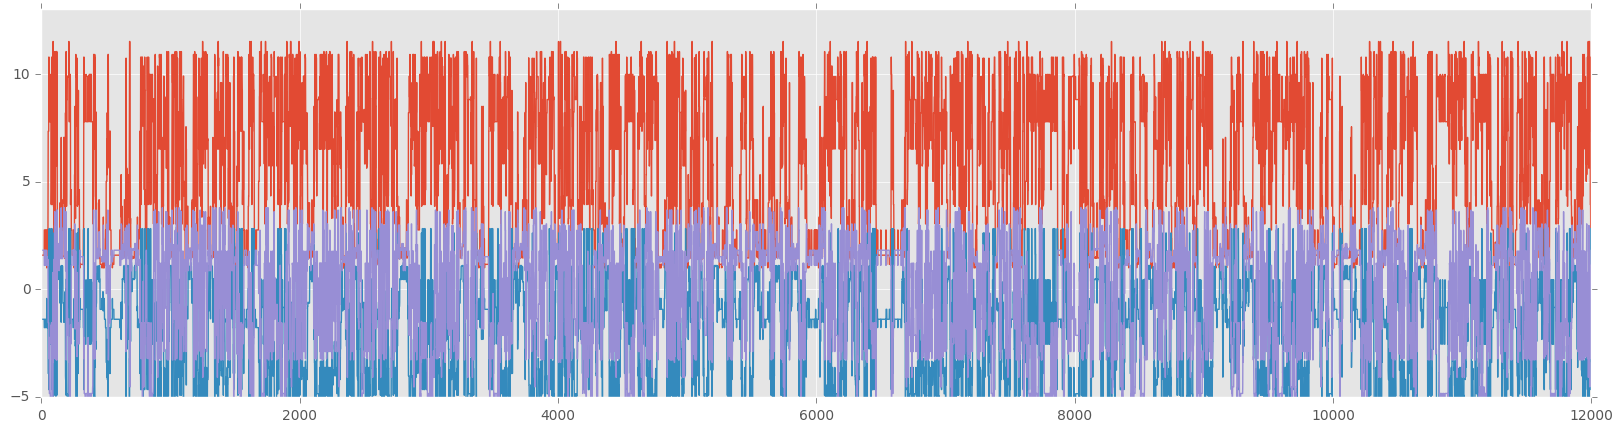

In [70]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_expects[:,3:]);
plt.ylim(-5,13);

## What happens if we use semilclassical system 1 obsevables? $Semi(S_1) \to S_2$ 

In [75]:
# hybrid_semi = build_markov.hybrid_model(slh_12,markov_builder,replacement_dict,single_kerr_obsq,delta_t,
#                                         name = 'sys_12_semi_diffusion')

In [72]:
# ## Best guess for HMM states of system 1
# sys1_clusters = hybrid_semi.markov_model_builder.hmm_model.predict(
#                     np.concatenate(np.asarray(mcdata_driven_kerr.expect[:3])).T)

### Original system 1


In [76]:
# plt.figure(figsize=(20,5))
# plt.plot(np.concatenate(mcdata_driven_kerr.expect).T[:,:3]);
# plt.ylim(-5,13);

### predicted state expectation for true trajectory of system 1

In [77]:
# plt.figure(figsize=(20,5))

# plt.plot(np.asarray([[hybrid_semi.markov_model_builder.expects_in_clusters[o][s] 
#       for o in hybrid_semi.markov_model_builder.obs_indices] 
#             for s in sys1_clusters]));
# plt.ylim(-5,13);

In [78]:
# Ntraj_12 = 1
# hybrid_semi.generate_trajectories(Tsim,Ntraj=Ntraj_12 , gen_state_index_lst = [sys1_clusters] )
# hybrid_semi.save()

# hybrid_semi.load()

In [79]:
# sys_12_semi_outputs = hybrid_semi.get_generated_trajs()

# Full $S_1 \to S_2$

In [107]:
slh_kerr_qnet_1, a_1_lst = make_kerr_slh(index = 1,which_symbols='qnet',params=params)
slh_kerr_qnet_2, a_2_lst = make_kerr_slh(index = 2,which_symbols='qnet',params=params)

In [108]:
slh_12_full = (slh_kerr_qnet_2 << slh_kerr_qnet_1 << Displace(alpha=params[alpha0])+cid(1)).toSLH()

In [109]:
a1 = a_1_lst[0]
a2 = a_2_lst[0]
a_lst = [a1,a2]
two_kerr_obs = tuple(itertools.chain.from_iterable([[a.dag()*a, a+a.dag(), (a-a.dag())/1j ]  
           for a in a_lst]))
two_kerr_obsq = [o.to_qutip(full_space=slh_12_full.space) for o in two_kerr_obs]

In [110]:
slh_12_full

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(49.0, IdentityOperator), ScalarTimesOperator(-2*sqrt(55), Destroy(LocalSpace('1', ''))), ScalarTimesOperator(2*sqrt(55), Destroy(LocalSpace('2', ''))))], [OperatorPlus(ScalarTimesOperator(-1.00000000000000e-5, Destroy(LocalSpace('1', ''))), ScalarTimesOperator(1.00000000000000e-5, Destroy(LocalSpace('2', ''))))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-220.000000000100, OperatorTimes(Create(LocalSpace('1', '')), Destroy(LocalSpace('2', '')))), ScalarTimesOperator(220.000000000100, OperatorTimes(Destroy(LocalSpace('1', '')), Create(LocalSpace('2', '')))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-49.0, OperatorPlus(ScalarTimesOperator(-2*sqrt(55), Create(LocalSpace('1', ''))), ScalarTimesOperator(2*sqrt(55), Create(LocalSpace('2', ''))))), ScalarTimesOperator(49.0, OperatorPlus(ScalarTimesOperator(-2*sqrt(55), Destroy(LocalSpace('1', ''))), ScalarTimesOperator(2*s

In [83]:
# mcdata_12 = make_traj(slh_12_full, Tsim, two_kerr_obsq)

In [84]:
# expect_full_12 = np.asarray(mcdata_12.expect)

In [85]:
# expect_full_1, expect_full_2 = np.split(expect_full_12,2,axis=1)

In [86]:
# plt.figure(figsize=(20,5))
# plt.plot(expect_full_1[0].T);
# plt.ylim(-5,13);

In [87]:
# plt.figure(figsize=(20,5))
# plt.plot(expect_full_2[0].T);
# plt.ylim(-5,13);

## Reducing full system 1+2

In [88]:
# dim_red_12_full= build_markov.dim_red_builder(Regime= "kerr_bistable_12",
#                 sample_type = 'all',
#                 mcdata = mcdata_12,)

# dim_red_12_full.run_diffusion_map(eig_upper_bound = 7,eps = 0.5,)

# markov_builder_12 = build_markov.markov_model_builder(dim_red_12_full)

# markov_builder_12.build_model(n_clusters = 60,which_coords = 'X',covariance_type='spherical')

In [89]:
# traj_red_12 = markov_builder_12.generate_obs_traj(int(duration))

In [90]:
# plt.figure(figsize=(20,5))
# plt.plot(traj_red_12[:3].T);
# plt.ylim(-5,13);

In [91]:
# plt.figure(figsize=(20,5))
# plt.plot(traj_red_12[3:].T);
# plt.ylim(-5,13);

## Comparing system 1 vs system 2 observables for reduced v. non-reduced 

In [92]:
# which_obs = 0  #### 0 -> N, 1 -> x, 2 -> p

### Full 1+2

In [93]:
# x,y = expect_full_12[0,which_obs,:],expect_full_2[0,which_obs,:]
# plot_density(x,y,s = 50)
# plt.xlim(0,14)
# plt.ylim(0,14)

### Making Clusters

In [94]:
# ## Data to cluster...
# X = np.vstack([x,y]).T

In [95]:
# labels_out, n_clusters_dbscan, core_samples_mask = run_DBSCAN(X, eps = 0.75,min_samples=200)
# plot_DBSCAN(X,labels_out,core_samples_mask)

### Transition times

In [96]:
# eps_try_full_12 = np.linspace(0.66,0.88, 20)

In [97]:
# cluster_analysis(eps_try_full_12)

### Reduced 1 into 2

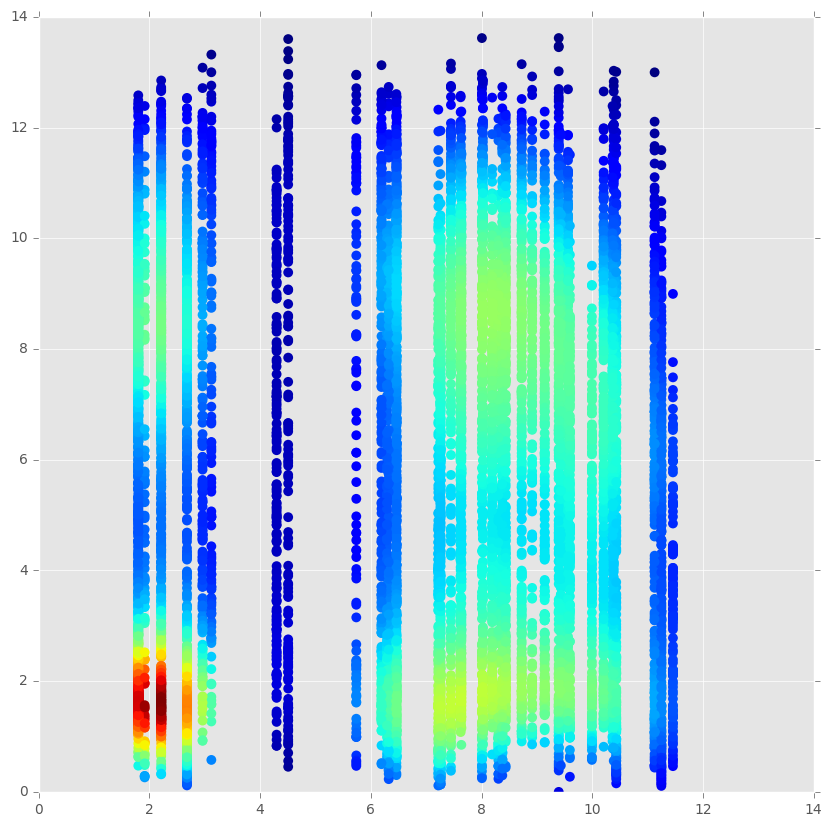

In [98]:
### Hybrid simulation
x,y = sys_12_outputs[0,:,which_obs], sys_12_outputs[0,:,3+which_obs]
plot_density(x,y,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

## Data to cluster...
X = np.vstack([x,y]).T

Estimated number of clusters: 2


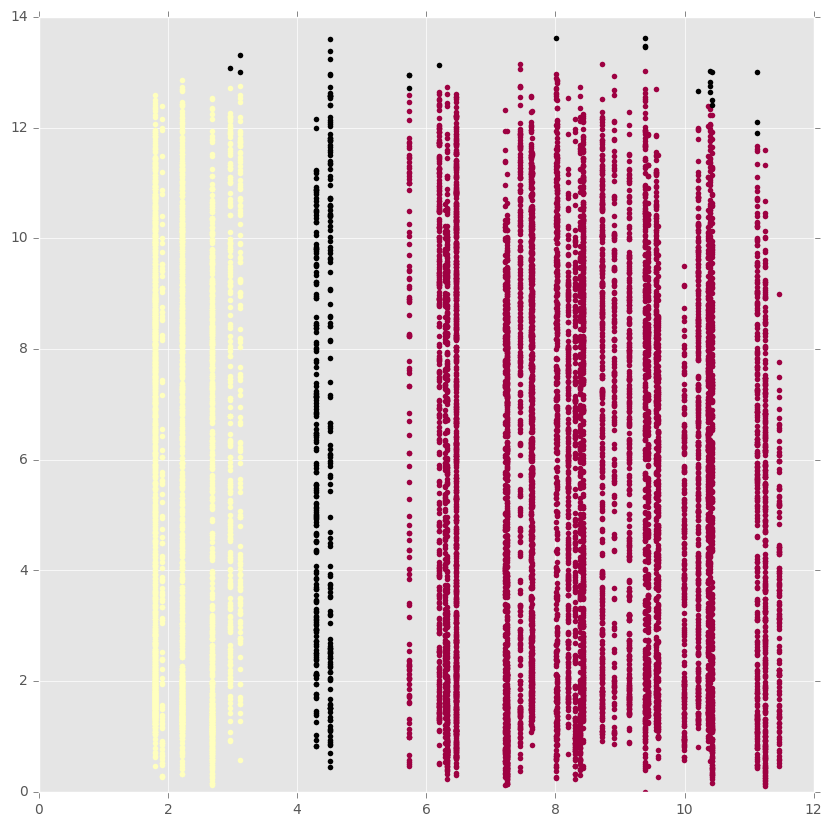

In [99]:
labels_red1, n_clusters_dbscan, core_samples_mask = run_DBSCAN(X, eps = 1.15
                                                               ,min_samples=200)
plot_DBSCAN(X,labels_red1,core_samples_mask)

In [100]:
eps_try_red1 = np.linspace(1.15,1.35, 20)

Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
Estimated number of clusters: 3
{0: {0: 0, 1: 1, 2: 2, -1: -1}, 1: {0: 0, 1: 1, 2: 2, -1: -1}, 2: {0: 0, 1: 1, 2: 2, -1: -1}, 3: {0: 0, 1: 1, 2: 2, -1: -1}, 4: {0: 0, 1: 1, 2: 2, -1: -1}, 5: {0: 0, 1: 1, 2: 2, -1: -1}, 6: {0: 0, 1: 1, 2: 2, -1: -1}, 7: {0: 0, 1: 1, 2: 2, -1: -1}, 8: {0: 0, 1: 1, 2: 2, -1: -1}, 9: {0: 0, 1: 1, 2: 2, -1: -1}, 10: {0: 0, 1: 1, 2: 2, -1: -1}, 11: {0: 0, 1: 1, 

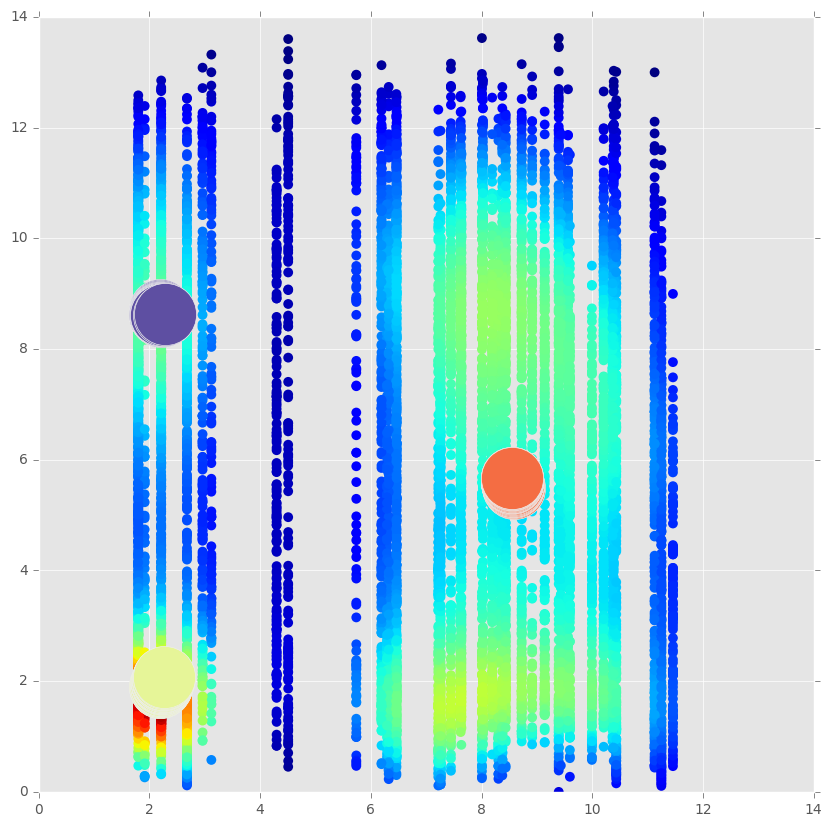

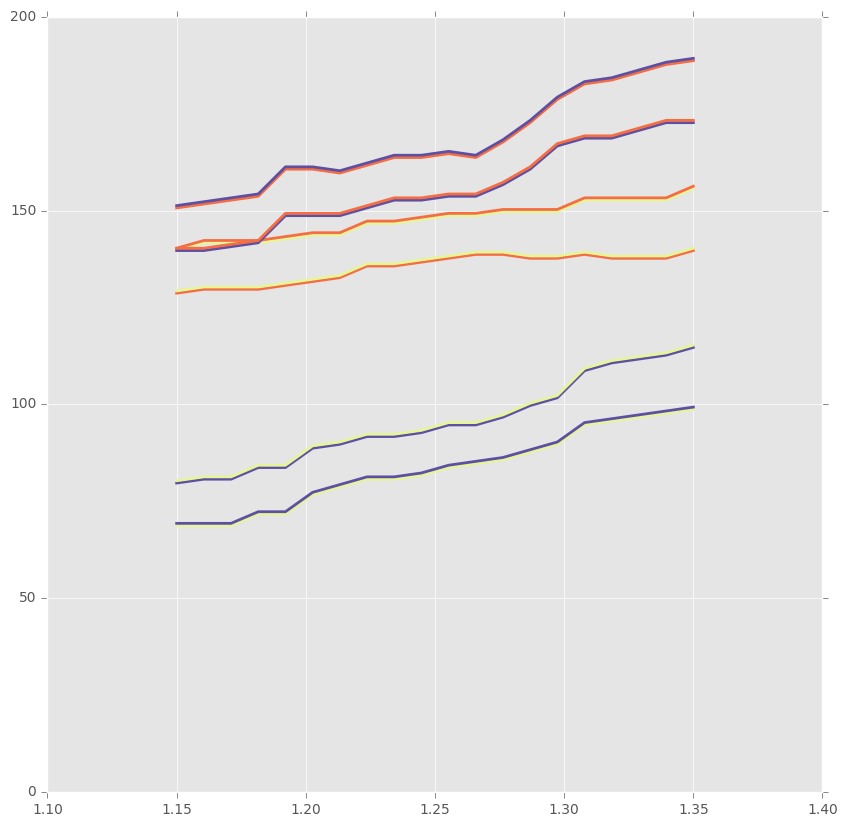

In [106]:
cluster_analysis(eps_try_red1, min_samples = 500,swap_colors={2:2,1:1,0:0})

## $semi(S_1) \to S_2$

In [ ]:
# ### Hybrid simulation
# x,y = sys_12_semi_outputs[0,:,which_obs], sys_12_semi_outputs[0,:,3+which_obs]
# plot_density(x,y,s = 50)
# plt.xlim(0,14)
# plt.ylim(0,14)

# ## Data to cluster...
# X = np.vstack([x,y]).T

In [ ]:
# labels_red1, n_clusters_dbscan, core_samples_mask = run_DBSCAN(X, eps = 0.7
#                                                                ,min_samples=200)
# plot_DBSCAN(X,labels_red1,core_samples_mask)

### Reduced (red(1)+2)

In [ ]:
# ### Hybrid simulation
# x,y = sys_12_expects[:,which_obs],sys_12_expects[:,3+which_obs]
# plot_density(x,y,s = 300)
# plt.xlim(0,14)
# plt.ylim(0,14)

In [ ]:
# ## Data to cluster...
# X = np.vstack([x,y]).T

In [ ]:
# labels_red1, n_clusters_dbscan, core_samples_mask = run_DBSCAN(X, eps = 2.13,min_samples=1000)
# plot_DBSCAN(X,labels_red1,core_samples_mask)

In [ ]:
# eps_try_red12 = np.linspace(1.9,2.12,20)

In [ ]:
# cluster_analysis(eps_try_red12, min_samples = 1000,swap_colors={2:1,1:2,0:0})

### Reduced (full 1+2)

In [ ]:
# ### Hybrid simulation
# x,y = traj_red_12[which_obs].T, traj_red_12[3 +which_obs].T
# plot_density(x,y,s = 300)

# Misc.

### Example on multiple trajs_per_generated_inputs.

In [ ]:
# hybrid.generate_trajectories(Tsim[:10],Ntraj=2,trajs_per_generated_inputs = 2)

In [ ]:
# sys_12_outputs = hybrid.get_generated_trajs()

In [ ]:
# sys_12_outputs.shape

#### We find above a tensor of shape [l,i,j,k] Here these represent: 
            l: Fixing a trajectory of system 1, the index of the trajectory
                of system 2 with the fixed trajectory of system 1.
            i: which trajectory
            j: which timestep
            k: index of which expectation value. The expectation values of
                systems 1 and 2 are staked.